In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

In [2]:
df = pd.read_csv('data/beyoncé.csv')
df.head()

,api_path,primary_artist,title,url,song_endpoint,album,release_date,lyrics
0,/songs/50396,Beyoncé,1+1,https://genius.com/Beyonce-1-1-lyrics,http://api.genius.com/songs/50396,4,2011-05-25,"If I ain't got nothing, I got you If I ain't ..."
1,/songs/2461229,Beyoncé,6 INCH,https://genius.com/Beyonce-6-inch-lyrics,http://api.genius.com/songs/2461229,Lemonade,2016-04-23,"Six inch heels, she walked in the club like n..."
2,/songs/587286,Beyoncé,7/11,https://genius.com/Beyonce-7-11-lyrics,http://api.genius.com/songs/587286,BEYONCÉ (Platinum Edition),2014-11-25,"Shoulders sideways, smack it, smack it in the..."
3,/songs/1852095,Beyoncé,After All Is Said And Done,https://genius.com/Beyonce-after-all-is-said-a...,http://api.genius.com/songs/1852095,The Best Man (Soundtrack),1999-09-09,"Here I am Looking in the mirror An open face,..."
4,/songs/919776,Beyoncé,All I Could Do Was Cry,https://genius.com/Beyonce-all-i-could-do-was-...,http://api.genius.com/songs/919776,Cadillac Records: Music From the Motion Picture,2008-12-02,I heard Church bells ringing I heard A choir s...


In [3]:
lexicon = pd.read_csv('sentiment_lexicons/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', delim_whitespace=True, header=None)
lexicon.head()

,0,1,2
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0
3,aback,fear,0
4,aback,joy,0


In [4]:
rs_lexicon = lexicon.pivot(index=0, columns=1, values=2)
rs_lexicon.drop(rs_lexicon.index[0], axis=0, inplace=True)
rs_lexicon.head()

1,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,,,,,,,,,,
aback,0,0,0,0,0,0,0,0,0,0
abacus,0,0,0,0,0,0,0,0,0,1
abandon,0,0,0,1,0,1,0,1,0,0
abandoned,1,0,0,1,0,1,0,1,0,0
abandonment,1,0,0,1,0,1,0,1,1,0


In [5]:
for col in rs_lexicon.columns:
    print(f'{col}: {rs_lexicon[col].sum()}')

anger: 1247
anticipation: 839
disgust: 1058
fear: 1476
joy: 689
negative: 3324
positive: 2312
sadness: 1191
surprise: 534
trust: 1231


In [6]:
vocabulary = list(rs_lexicon.index)
emotions = {}
for word in vocabulary:
    rs_lex_filtered = rs_lexicon.loc[[word]]
    values = [col for col in rs_lex_filtered.columns if int(rs_lex_filtered[col].values) == 1]
    if values != []:
        emotions[word] = values

In [7]:
emotions

{'abacus': ['trust'],
 'abandon': ['fear', 'negative', 'sadness'],
 'abandoned': ['anger', 'fear', 'negative', 'sadness'],
 'abandonment': ['anger', 'fear', 'negative', 'sadness', 'surprise'],
 'abba': ['positive'],
 'abbot': ['trust'],
 'abduction': ['fear', 'negative', 'sadness', 'surprise'],
 'aberrant': ['negative'],
 'aberration': ['disgust', 'negative'],
 'abhor': ['anger', 'disgust', 'fear', 'negative'],
 'abhorrent': ['anger', 'disgust', 'fear', 'negative'],
 'ability': ['positive'],
 'abject': ['disgust', 'negative'],
 'abnormal': ['disgust', 'negative'],
 'abolish': ['anger', 'negative'],
 'abolition': ['negative'],
 'abominable': ['disgust', 'fear', 'negative'],
 'abomination': ['anger', 'disgust', 'fear', 'negative'],
 'abort': ['negative'],
 'abortion': ['disgust', 'fear', 'negative', 'sadness'],
 'abortive': ['negative', 'sadness'],
 'abovementioned': ['positive'],
 'abrasion': ['negative'],
 'abrogate': ['negative'],
 'abrupt': ['surprise'],
 'abscess': ['negative', 'sad

In [8]:
corpus = []
tokenizer = RegexpTokenizer(r'\w\w+') 
lemmatizer = WordNetLemmatizer()
for lyric in df['lyrics']:
    token = tokenizer.tokenize(lyric.lower())
    lemmatized_token = []
    for word in token:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_token.append(lemmatized_word)
    corpus.append(lemmatized_token)

In [9]:
song_emotions = []
for song in corpus:
    emotion_count = {'anger': 0, 
                     'positive': 0,
                     'negative': 0,
                     'anticipation': 0, 
                     'disgust': 0,
                     'fear': 0, 
                     'joy': 0, 
                     'sadness': 0, 
                     'surprise': 0, 
                     'trust': 0} 
    for word in song:
        if word in emotions.keys():
            word_emotions = emotions[word]
            if word_emotions != []:
                for emotion in word_emotions:
                    emotion_count[emotion] += 1
    song_emotions.append(emotion_count)

In [10]:
df = pd.concat([df, pd.DataFrame(song_emotions)], axis=1)

In [18]:
df_normalized = df.groupby('release_date')[['anger', 'positive', 'negative', 'anticipation', 
                                            'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']].sum()

df_normalized.head()
for col in df_normalized.columns:
    df_normalized[col] = df_normalized[col].apply(int)

In [19]:
sums = df_normalized['anger'] + df_normalized['positive'] + df_normalized['negative'] + df_normalized['anticipation'] + df_normalized['disgust'] + df_normalized['fear'] + df_normalized['joy'] + df_normalized['sadness'] + df_normalized['surprise'] + df_normalized['trust']   
df_normalized['sum'] = sums
df_normalized.head()

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
1999-09-09,1,20,4,9,0,5,18,1,7,11,76
2002-01-01,34,119,57,47,27,27,46,32,28,88,505
2002-06-11,3,17,6,9,3,3,7,2,6,10,66
2002-07-16,1,70,4,0,1,1,11,1,0,1,90
2003-06-22,9,24,36,12,31,6,18,12,13,14,175


In [20]:
df_normalized.index = pd.to_datetime(df_normalized.index)
df_normalized = df_normalized.resample('Y').sum()
df_normalized.head()

In [27]:
cols = list(df_normalized.columns)
zeros = (df_normalized.anger == 0) & (df_normalized.positive == 0) & (df_normalized.negative == 0) & (df_normalized.anticipation == 0) & (df_normalized.disgust == 0) & (df_normalized.fear == 0) & (df_normalized.joy == 0) & (df_normalized.sadness == 0) & (df_normalized.surprise == 0) & (df_normalized.trust == 0) 
df_normalized.drop(df_normalized[zeros].index, axis=0, inplace=True)
df_normalized

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
1999-12-31,1,20,4,9,0,5,18,1,7,11,76
2002-12-31,38,206,67,56,31,31,64,35,34,99,661
2003-12-31,137,727,347,315,166,147,538,145,189,361,3072
2005-12-31,1,44,6,31,0,7,29,5,7,16,146
2006-12-31,156,410,300,203,155,149,208,173,99,246,2099
2007-12-31,18,144,74,18,17,29,90,39,9,52,490
2008-12-31,70,225,139,78,46,100,141,102,31,141,1073
2009-12-31,79,164,127,80,53,99,86,88,30,97,903
2010-12-31,10,102,17,15,11,7,55,6,6,49,278


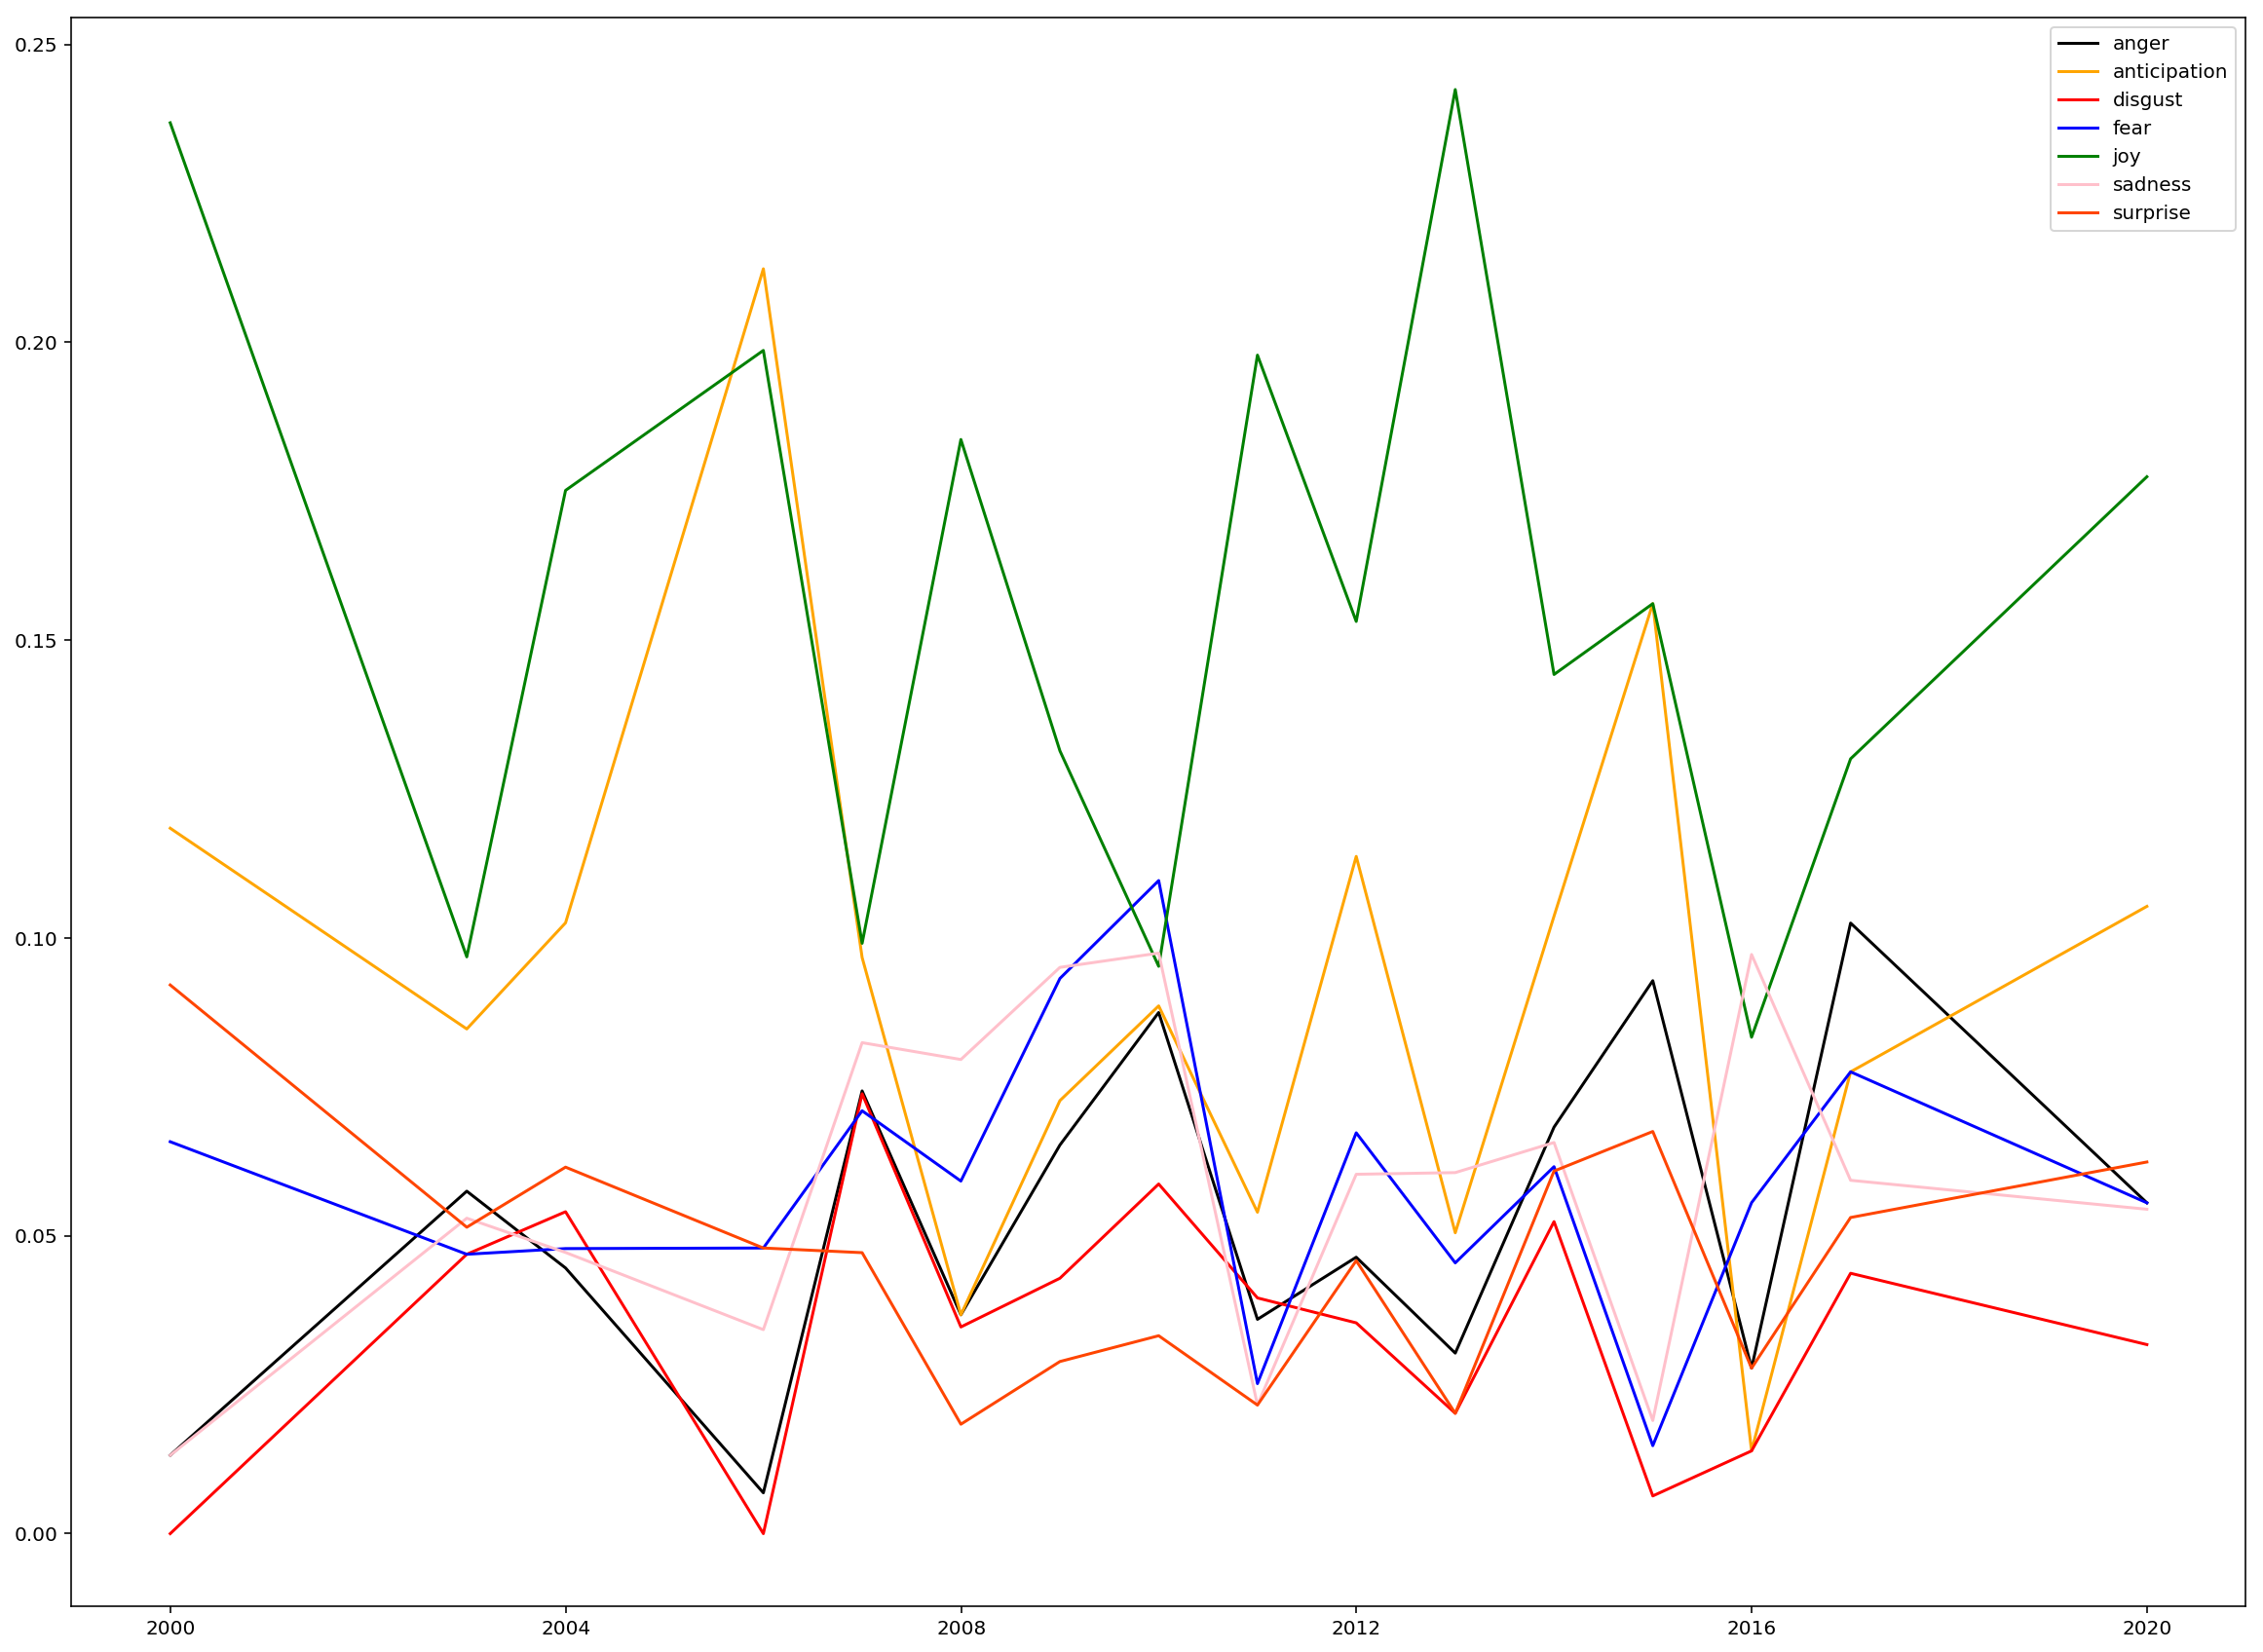

In [33]:
plt.figure(figsize=(20, 15))
plt.plot(df_normalized.index, df_normalized.anger, label='anger', c='k');
plt.plot(df_normalized.index, df_normalized.anticipation, label='anticipation', c='orange');
plt.plot(df_normalized.index, df_normalized.disgust, label='disgust', c='red');
plt.plot(df_normalized.index, df_normalized.fear, label='fear', c='blue');
plt.plot(df_normalized.index, df_normalized.joy, label='joy', c='green');
plt.plot(df_normalized.index, df_normalized.sadness, label='sadness', c='pink');
plt.plot(df_normalized.index, df_normalized.surprise, label='surprise', c='orangered');
plt.legend();

In [29]:
cols.remove('sum')
for col in cols:
    df_normalized[col] = df_normalized[col] / df_normalized['sum']

In [31]:
df_normalized

,anger,positive,negative,anticipation,disgust,fear,joy,sadness,surprise,trust,sum
release_date,,,,,,,,,,,
1999-12-31,0.013158,0.263158,0.052632,0.118421,0.000000,0.065789,0.236842,0.013158,0.092105,0.144737,76
2002-12-31,0.057489,0.311649,0.101362,0.084720,0.046899,0.046899,0.096823,0.052950,0.051437,0.149773,661
2003-12-31,0.044596,0.236654,0.112956,0.102539,0.054036,0.047852,0.175130,0.047201,0.061523,0.117513,3072
2005-12-31,0.006849,0.301370,0.041096,0.212329,0.000000,0.047945,0.198630,0.034247,0.047945,0.109589,146
2006-12-31,0.074321,0.195331,0.142925,0.096713,0.073845,0.070986,0.099095,0.082420,0.047165,0.117199,2099
2007-12-31,0.036735,0.293878,0.151020,0.036735,0.034694,0.059184,0.183673,0.079592,0.018367,0.106122,490
2008-12-31,0.065238,0.209692,0.129543,0.072693,0.042870,0.093197,0.131407,0.095061,0.028891,0.131407,1073
2009-12-31,0.087486,0.181617,0.140642,0.088594,0.058693,0.109635,0.095238,0.097453,0.033223,0.107420,903
2010-12-31,0.035971,0.366906,0.061151,0.053957,0.039568,0.025180,0.197842,0.021583,0.021583,0.176259,278


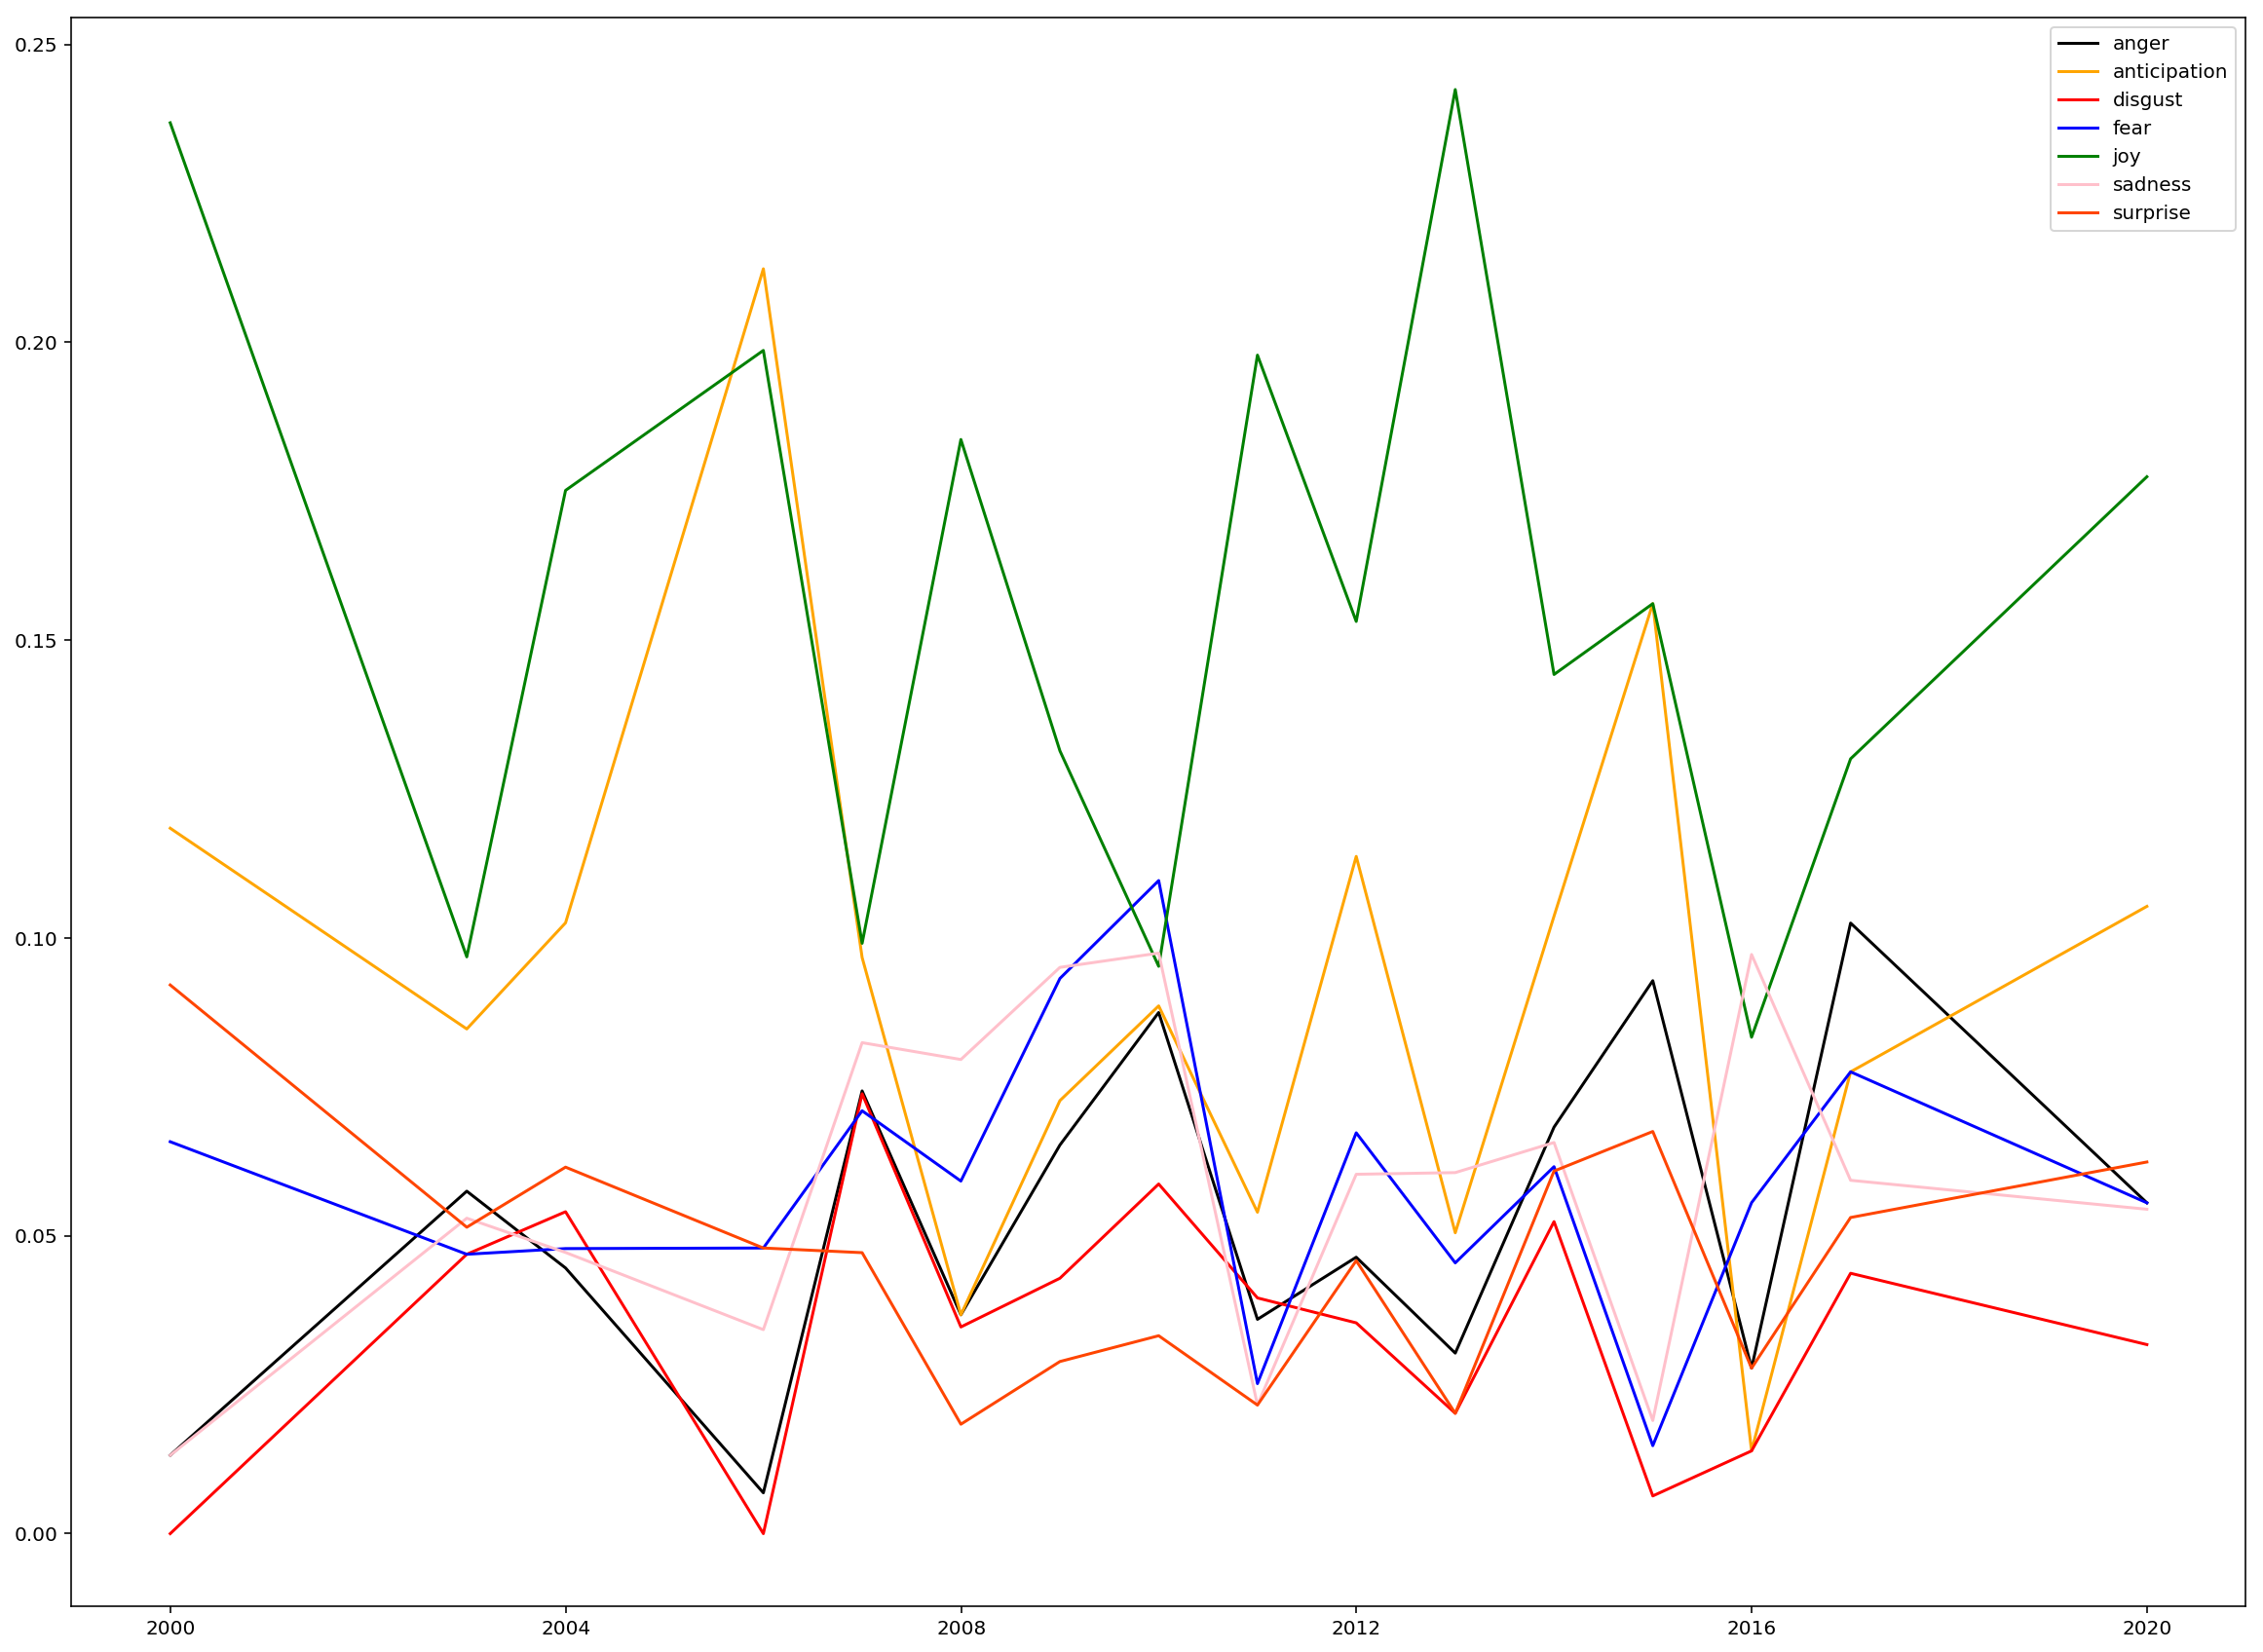

In [32]:
plt.figure(figsize=(20, 15))
plt.plot(df_normalized.index, df_normalized.anger, label='anger', c='k');
plt.plot(df_normalized.index, df_normalized.anticipation, label='anticipation', c='orange');
plt.plot(df_normalized.index, df_normalized.disgust, label='disgust', c='red');
plt.plot(df_normalized.index, df_normalized.fear, label='fear', c='blue');
plt.plot(df_normalized.index, df_normalized.joy, label='joy', c='green');
plt.plot(df_normalized.index, df_normalized.sadness, label='sadness', c='pink');
plt.plot(df_normalized.index, df_normalized.surprise, label='surprise', c='orangered');
plt.legend();